Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

from numpy.linalg import solve, norm
from scipy.cluster.hierarchy import fcluster

warnings.filterwarnings("ignore")

path = os.getcwd()
print(path)
os.chdir(path)



/Users/ruimaciel/Desktop/Barcelona/ML_Finance/2nd_homework_ml


### Aux Functions

In [2]:
def log_return(df):
    return np.log(df).diff().drop(index=df.index[0], axis=0, inplace=False)

def na_fill(df):
    # Simulates `na.fill(as.xts(rowAvgs(df),order.by=index(df)),"extend")`
    return df.interpolate(method="linear").fillna(method="bfill")

def create_index(df):
    # the linear method already does ffill for the tail values
    return na_fill(df.mean(axis=1, skipna=False))

def cov2cor(df):
    ind = df.index
    col = df.columns
    sigma = np.sqrt(np.diag(df))
    return df.div(pd.DataFrame(np.outer(sigma, sigma), index=ind, columns=col))

def clusterplot(cov, ncluster=6):
    sns.set(style='white')
    sns_plot = sns.clustermap(cov2cor(cov), cmap='vlag_r', robust=True, method="complete", vmin=-1, vmax=1)
    plt.setp(sns_plot.ax_heatmap.yaxis.get_majorticklabels(), fontsize=14, color='red')  # Corrected here
    plt.setp(sns_plot.ax_heatmap.xaxis.get_majorticklabels(), fontsize=14, color='red')  # Corrected here
    plt.title("Correlation")

    Z = sns_plot.dendrogram_row.linkage
    clusters = list(fcluster(Z, ncluster, criterion='maxclust'))
    assign_cluster = dict((k, clusters[k]) for k in range(len(cov.columns)))
    assigned_idx = [assign_cluster[idx] for idx in sns_plot.dendrogram_row.reordered_ind]
    i = 0
    while i < len(assigned_idx):
        cluster = assigned_idx[i]
        counter = 0
        while i < len(assigned_idx) and assigned_idx[i] == cluster:
            counter += 1
            i += 1
        sns_plot.ax_heatmap.add_patch(plt.Rectangle(
            xy=(i-counter, i-counter),
            width=counter,
            height=counter,
            fill=None, color='black', lw=1.5
        ))
    plt.show()


# Load stocks price and select our time frame and stocks


In [3]:
import pandas as pd

begin_date = "2015-01-01"
end_date = "2016-12-31"
columns_to_drop= ['JPM', 'KO', 'MCD', 'MSFT', 'PFE', 'XOM']

# Load stock data
stocks = pd.read_csv('adjusted.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks[(stocks['Date'] >= begin_date) & (stocks['Date'] <= end_date)]
stocks = stocks.drop(columns=columns_to_drop)

# Load PNlog data
PNlog = pd.read_csv("PNlog.csv")
PNlog['Date'] = pd.to_datetime(PNlog['Date'])
PNlog = PNlog[(PNlog['Date'] >= begin_date) & (PNlog['Date'] <= end_date)]
PNlog = PNlog.drop(columns=columns_to_drop)

In [4]:
stocks

,Date,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
1,2015-01-02,99.945885,51.718132,308.519989,28.562273,87.376266,78.449997,523.373108,34.983353,33.575310
2,2015-01-05,97.130241,50.744839,302.190002,27.015579,86.099403,77.190002,512.463013,34.292366,32.804939
3,2015-01-06,97.139420,50.493664,295.290009,26.584383,85.642708,76.150002,500.585632,33.955738,32.327015
4,2015-01-07,98.501518,52.534447,298.420013,26.865599,86.518814,76.150002,499.727997,34.868195,32.576675
5,2015-01-08,102.286186,53.083889,300.459991,26.921841,87.413536,78.180000,501.303680,35.621181,32.683674
...,...,...,...,...,...,...,...,...,...,...
500,2016-12-23,110.743988,52.492733,760.590027,17.915533,100.693771,117.269997,789.909973,50.292454,32.497345
501,2016-12-27,111.447319,52.627453,771.400024,17.665504,100.712914,118.010002,791.549988,50.356640,32.497345
502,2016-12-28,110.972122,52.433788,772.130005,17.232763,99.879791,116.919998,785.049988,49.797234,32.415836
503,2016-12-29,110.943588,52.821125,765.150024,17.136597,100.128761,116.349998,782.789978,49.558796,32.415836


In [5]:
PNlog

,Date,AAPL,ABBV,AMZN,DB,DIS,FB,GOOG,HAL,HSBC
0,2015-01-02,0.010336,-0.015882,-0.020067,0.004023,0.008930,-0.010094,0.007672,0.001855,-0.037944
1,2015-01-05,0.014229,0.000000,0.013374,0.008442,0.010258,0.011148,-0.002559,-0.012387,-0.023388
2,2015-01-06,0.017950,0.010092,0.019457,-0.005736,-0.016278,0.007027,0.017585,0.019216,-0.035777
3,2015-01-07,0.000000,0.010801,-0.010497,0.010894,-0.002005,0.010447,-0.004112,0.003567,-0.021697
4,2015-01-08,0.005537,0.007774,0.010360,-0.003153,0.041047,-0.003588,0.015942,0.001991,-0.009976
...,...,...,...,...,...,...,...,...,...,...
499,2016-12-23,-0.046832,-0.015995,0.001139,0.000000,0.000000,0.000000,0.019631,NaN,-0.005752
500,2016-12-27,-0.001563,NaN,0.007011,0.000000,0.007284,-0.035964,0.009811,-0.028647,NaN
501,2016-12-28,0.001133,NaN,0.000000,-0.003170,0.018131,-0.035765,0.015583,-0.040662,-0.003455
502,2016-12-29,-0.019729,NaN,-0.008228,0.004028,-0.044793,-0.053111,0.007714,0.000000,-0.011610


# Preprocess the data

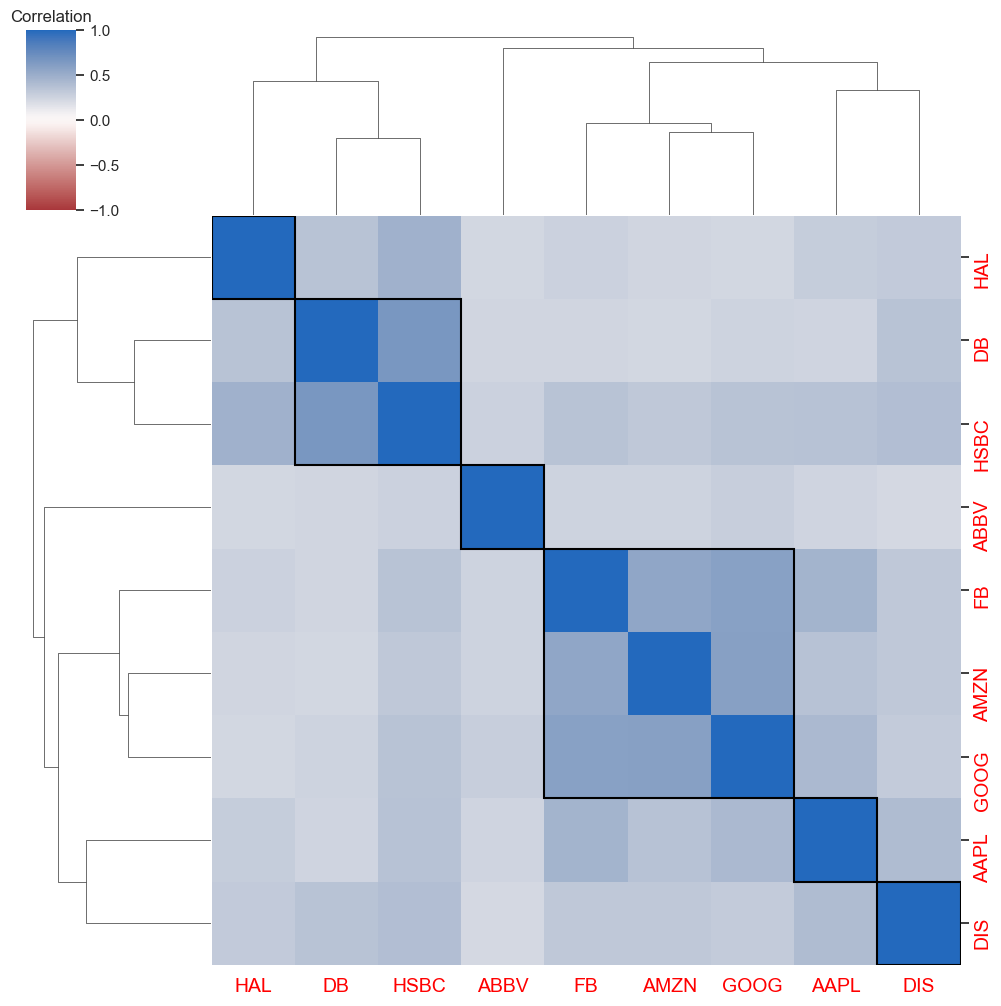

In [6]:
# Processing the data
stocks.set_index('Date', inplace=True)
PNlog.set_index('Date', inplace=True)

# Calculate log returns for stocks and PNlog
X = log_return(stocks)

# Create market index from PNlog
PNlog_indexed = create_index(PNlog)

# Check alignment and apply na_fill if necessary
X = na_fill(X)

# Example correlation and cluster plotting (optional, on demand)
cov_matrix = X.cov()
clusterplot(cov_matrix)

Cluster Identification:
- Cluster 1: Comprising DB (Deutsche Bank) and HSBC (HSBC Holdings). This cluster groups together stocks from the financial sector, specifically major global banking institutions.
- Cluster 2: Consisting of FB (Facebook), AMZN (Amazon), and GOOG (Google). These are tech giants that, despite operating in different niches within the sector—social media for Facebook, e-commerce for Amazon, and search and advertising for Google—show similar stock movement patterns.
1. Analysis of Intra-Cluster Correlations:
DB and HSBC: Exhibiting strong positive correlations. This similarity in movement can be attributed to their exposure to similar economic, regulatory, and market conditions affecting the banking sector globally. Factors such as interest rate changes, financial regulations, and economic indicators that influence the banking sector could be causing these stocks to move in concert.
FB, AMZN, and GOOG: Also displaying strong positive correlations. These correlations likely stem from shared market drivers like technological advancements, shifts in digital consumer behavior, and common regulatory challenges impacting the tech industry. Changes in one area of technology or consumer behavior can similarly affect all these stocks due to their interconnectedness within the digital economy.

In [7]:
#Check missing data
PNlog_indexed.isnull().sum()

0

In [8]:
# Sentiment Index - already aligned and filled
SentIndx = PNlog_indexed

# Create DataFrame for linear regression with a constant term
F = SentIndx.copy().to_frame()
F.insert(0, 'ones', 1)  # Adding a constant term for regression

# Calculate number of observations and number of stocks
T, N = X.shape  # T = number of rows (time periods), N = number of columns (stocks)

# Split data into training and test sets
T_trn = round(0.5*T)
X_trn = X.iloc[0:T_trn, ]
X_tst = X.iloc[T_trn:T, ]
SentIndx_trn = SentIndx.iloc[0:T_trn,]
SentIndx_tst = SentIndx.iloc[T_trn:T,]

# Regression to find alpha and beta parameters using training data

In [9]:
Gamma = pd.DataFrame(solve(F.iloc[0:T_trn].T @ F.iloc[0:T_trn], F.iloc[0:T_trn].T.to_numpy() @ X_trn.to_numpy()).T, columns=["alpha", "beta"])
alpha = Gamma["alpha"]
beta = Gamma["beta"]

# Calculate residuals to estimate specific risks
E = pd.DataFrame((X_trn.T - (Gamma.to_numpy() @ F.iloc[0:T_trn].to_numpy().T)).T, index=X_trn.index)
Psi_Sent = (E.T @ E) / (T_trn - 2)  # Estimating specific risks

# Calculate the perturbation matrix using the sentiment index
Sigma_SentInx = SentIndx_trn.var() * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
Sigma_SentInx

array([[ 2.84714780e-04, -5.94364541e-08,  3.40698361e-07,
         5.24042541e-07,  2.35127444e-07,  4.35509062e-07,
         1.20897526e-07, -1.90936308e-07, -3.43596601e-07],
       [-5.94364541e-08,  4.09368424e-04, -5.98015430e-08,
        -9.19832794e-08, -4.12710643e-08, -7.64433200e-08,
        -2.12207027e-08,  3.35143550e-08,  6.03102604e-08],
       [ 3.40698361e-07, -5.98015430e-08,  4.40505291e-04,
         5.27261477e-07,  2.36571717e-07,  4.38184180e-07,
         1.21640141e-07, -1.92109136e-07, -3.45707146e-07],
       [ 5.24042541e-07, -9.19832794e-08,  5.27261477e-07,
         4.03229736e-04,  3.63880951e-07,  6.73989596e-07,
         1.87099838e-07, -2.95491177e-07, -5.31746764e-07],
       [ 2.35127444e-07, -4.12710643e-08,  2.36571717e-07,
         3.63880951e-07,  2.07285313e-04,  3.02405700e-07,
         8.39479687e-08, -1.32581002e-07, -2.38584176e-07],
       [ 4.35509062e-07, -7.64433200e-08,  4.38184180e-07,
         6.73989596e-07,  3.02405700e-07,  2.650415

# Trying different Kappas and noise

In [10]:
# Define kappa values and noise levels
kappa_values = [0.05, 0.5, 1.5, 3.0]
noise_levels = [0.01, 0.05, 0.1, 0.2]


## Impact of Kappa and Noise Levels

### Kappa (Robustness Parameter)
- **Low Kappa Values**: The robustness term \(\kappa \cdot w^T \Sigma w\) has less influence on the objective function. The optimization will prioritize maximizing expected returns, potentially leading to more concentrated portfolios with higher weights on high-return assets, regardless of their risk.
- **High Kappa Values**: The robustness term becomes more significant. The optimization will place more emphasis on minimizing variance, leading to more diversified portfolios with reduced exposure to high-risk assets. This means the portfolio will be more risk-averse and better at handling uncertainty.

### Noise Levels
- **Low Noise Levels**: The covariance matrix \(\Sigma_{\text{noisy\_SentInx}}\) remains closer to the original covariance structure of the assets. This means the robustness term will reflect more accurate risk estimates, leading to more precise adjustments in portfolio weights.
- **High Noise Levels**: As noise increases, the covariance matrix becomes less reliable, introducing more uncertainty into the risk estimates. This can lead to more conservative weight adjustments, with the optimizer potentially spreading weights more evenly across assets to mitigate the increased perceived risk.



## Kappa Values (κ)
Kappa values represent the weight given to the robustness term in your objective function. Higher values indicate a greater emphasis on minimizing variance relative to maximizing returns, which corresponds to a higher risk aversion.

- **Low Risk Aversion**: `0.05`
  - Suitable for aggressive investment strategies where the focus is primarily on maximizing returns.
- **Medium-Low Risk Aversion**: `0.5`
  - A conservative approach compared to the lowest level, but still aiming for substantial returns with moderate risk management.
- **Medium-High Risk Aversion**: `1.5`
  - Provides a balanced approach, where returns and risk mitigation are both important, suitable for most average risk-tolerance portfolios.
- **High Risk Aversion**: `3.0`
  - Focuses heavily on risk control, ideal for portfolios that need to maintain stability in volatile or uncertain market conditions.

## Noise Levels
Noise levels simulate the degree of uncertainty or error in the sentiment index. They can represent the potential volatility or estimation errors in the sentiment data.

- **Low Noise**: `0.01`
  - Represents scenarios with minimal estimation errors or market volatility. Suitable for stable market conditions.
- **Medium-Low Noise**: `0.05`
  - Moderate uncertainty, reflecting slight inaccuracies in sentiment analysis or mild market volatility.
- **Medium-High Noise**: `0.1`
  - Higher levels of uncertainty, suitable for testing portfolio resilience under more volatile or less predictable market conditions.
- **High Noise**: `0.2`
  - Very high levels of uncertainty, testing how the portfolio would perform under extreme conditions of data inaccuracy or market instability.


In [11]:
# Apply noise and recalcute the covariance matrix

def apply_noise_and_recalculate(SentIndx, X, beta, Psi_Sent, noise_level):
    noisy_SentIndx = SentIndx + np.random.normal(0, noise_level, SentIndx.shape)
    # Recalculate variance with noise
    var_noisy = noisy_SentIndx.var()
    Sigma_noisy_SentInx = var_noisy * np.outer(beta, beta) + np.diag(np.diag(Psi_Sent))
    return Sigma_noisy_SentInx



In [12]:
import cvxpy as cp

results = []

for kappa in kappa_values:
    for noise_level in noise_levels:
        Sigma_noisy_SentInx = apply_noise_and_recalculate(SentIndx_trn, X_trn, beta, Psi_Sent, noise_level)

        # Define optimization variables
        w = cp.Variable(N)

        # Objective function components
        expected_return = w.T @ alpha
        robustness_term = kappa * cp.quad_form(w, Sigma_noisy_SentInx)
        regularization_term = 0.01 * cp.norm(w, 1)  # L1 regularization to promote sparsity

        # Maximize expected returns adjusted for robustness and regularization
        objective = cp.Maximize(expected_return - robustness_term - regularization_term)
        constraints = [cp.sum(w) == 1, w >= 0]  # Sum of weights must be 1, no short selling
        
        # Problem setup and solve
        prob = cp.Problem(objective, constraints)
        prob.solve()
        
        # Store results
        results.append({
            'kappa': kappa,
            'noise_level': noise_level,
            'portfolio_weights': w.value
        })

# Print results
for result in results:
    print(f"Kappa: {result['kappa']}, Noise: {result['noise_level']}, Weights: {result['portfolio_weights']}")

Kappa: 0.05, Noise: 0.01, Weights: [1.14610499e-05 1.14641023e-05 9.99908270e-01 1.14636699e-05
 1.14593266e-05 1.14605483e-05 1.14622270e-05 1.14658234e-05
 1.14588045e-05]
Kappa: 0.05, Noise: 0.05, Weights: [1.11205904e-05 1.11268122e-05 9.99910982e-01 1.11220266e-05
 1.11195090e-05 1.11193347e-05 1.11234656e-05 1.11296316e-05
 1.11232366e-05]
Kappa: 0.05, Noise: 0.1, Weights: [1.00716486e-05 1.00897938e-05 9.99919328e-01 1.00681096e-05
 1.00733072e-05 1.00675247e-05 1.00809754e-05 1.00966528e-05
 1.00936638e-05]
Kappa: 0.05, Noise: 0.2, Weights: [2.00278737e-05 1.91049904e-05 9.99843457e-01 2.03963222e-05
 1.98263689e-05 2.02487001e-05 1.95307520e-05 1.87888727e-05
 1.85613760e-05]
Kappa: 0.5, Noise: 0.01, Weights: [-5.53682474e-06 -5.67540417e-06  1.00004463e+00 -5.65755550e-06
 -5.45720996e-06 -5.51409730e-06 -5.59012698e-06 -5.75354217e-06
 -5.43119027e-06]
Kappa: 0.5, Noise: 0.05, Weights: [-5.21371593e-06 -5.45191353e-06  1.00004249e+00 -5.26645999e-06
 -5.17357150e-06 -5.16535

# Visualizations of results

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
# Putting results into a DataFrame
results_df = pd.DataFrame(results)

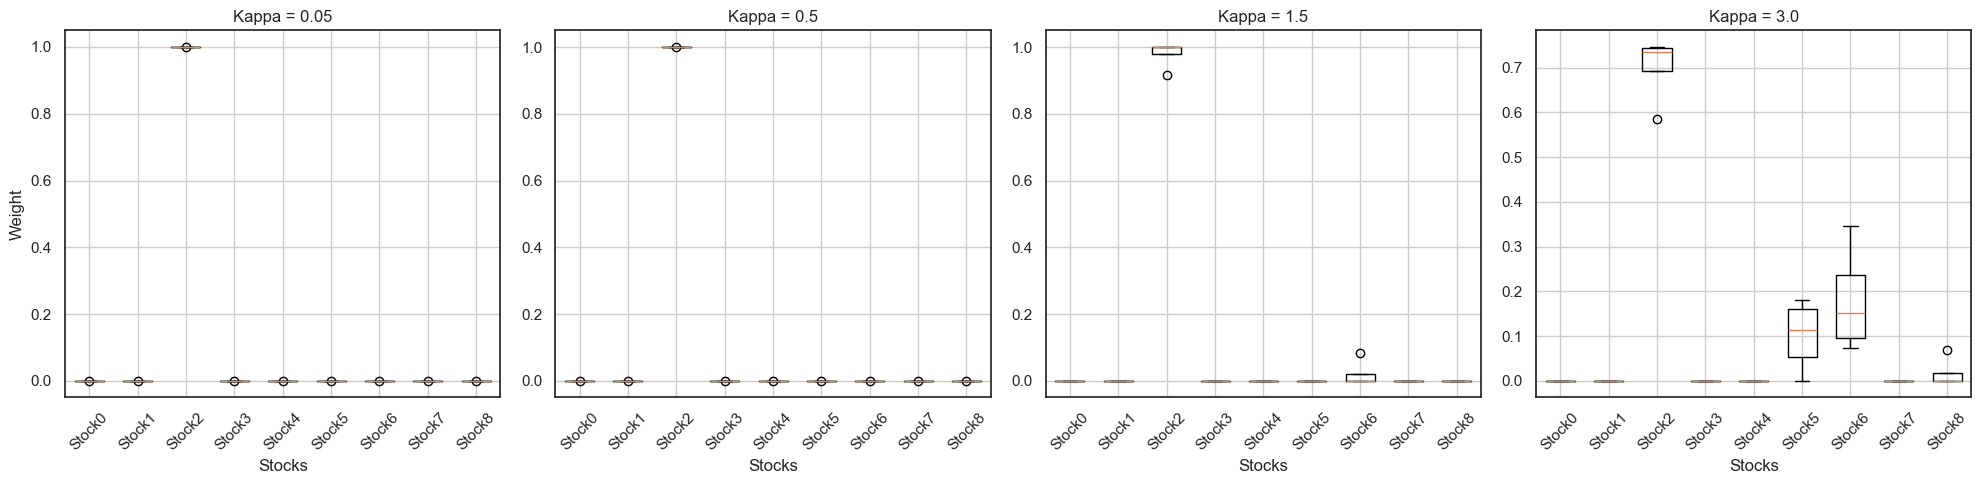

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract weights for each kappa
def get_weights_for_kappa(kappa, results_df):
    subset = results_df[results_df['kappa'] == kappa]
    weights_matrix = np.array(subset['portfolio_weights'].tolist())
    return weights_matrix

# Prepare to plot all kappa values in a single row
fig, axes = plt.subplots(1, len(kappa_values), figsize=(20, 5))  # Adjust figure size as needed

for idx, kappa in enumerate(kappa_values):
    weights_matrix = get_weights_for_kappa(kappa, results_df)
    
    # Plot on the corresponding subplot axis
    ax = axes[idx] if len(kappa_values) > 1 else axes  # Handle the case if there's only one kappa
    ax.boxplot(weights_matrix, positions=range(1, N + 1), widths=0.6)
    ax.set_title(f'Kappa = {kappa}')
    ax.set_xlabel('Stocks')
    if idx == 0:  # Only add y-label to the first subplot to avoid clutter
        ax.set_ylabel('Weight')
    ax.set_xticks(range(1, N + 1))
    ax.set_xticklabels([f'Stock{i}' for i in range(N)], rotation=45)
    ax.grid(True)

plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()



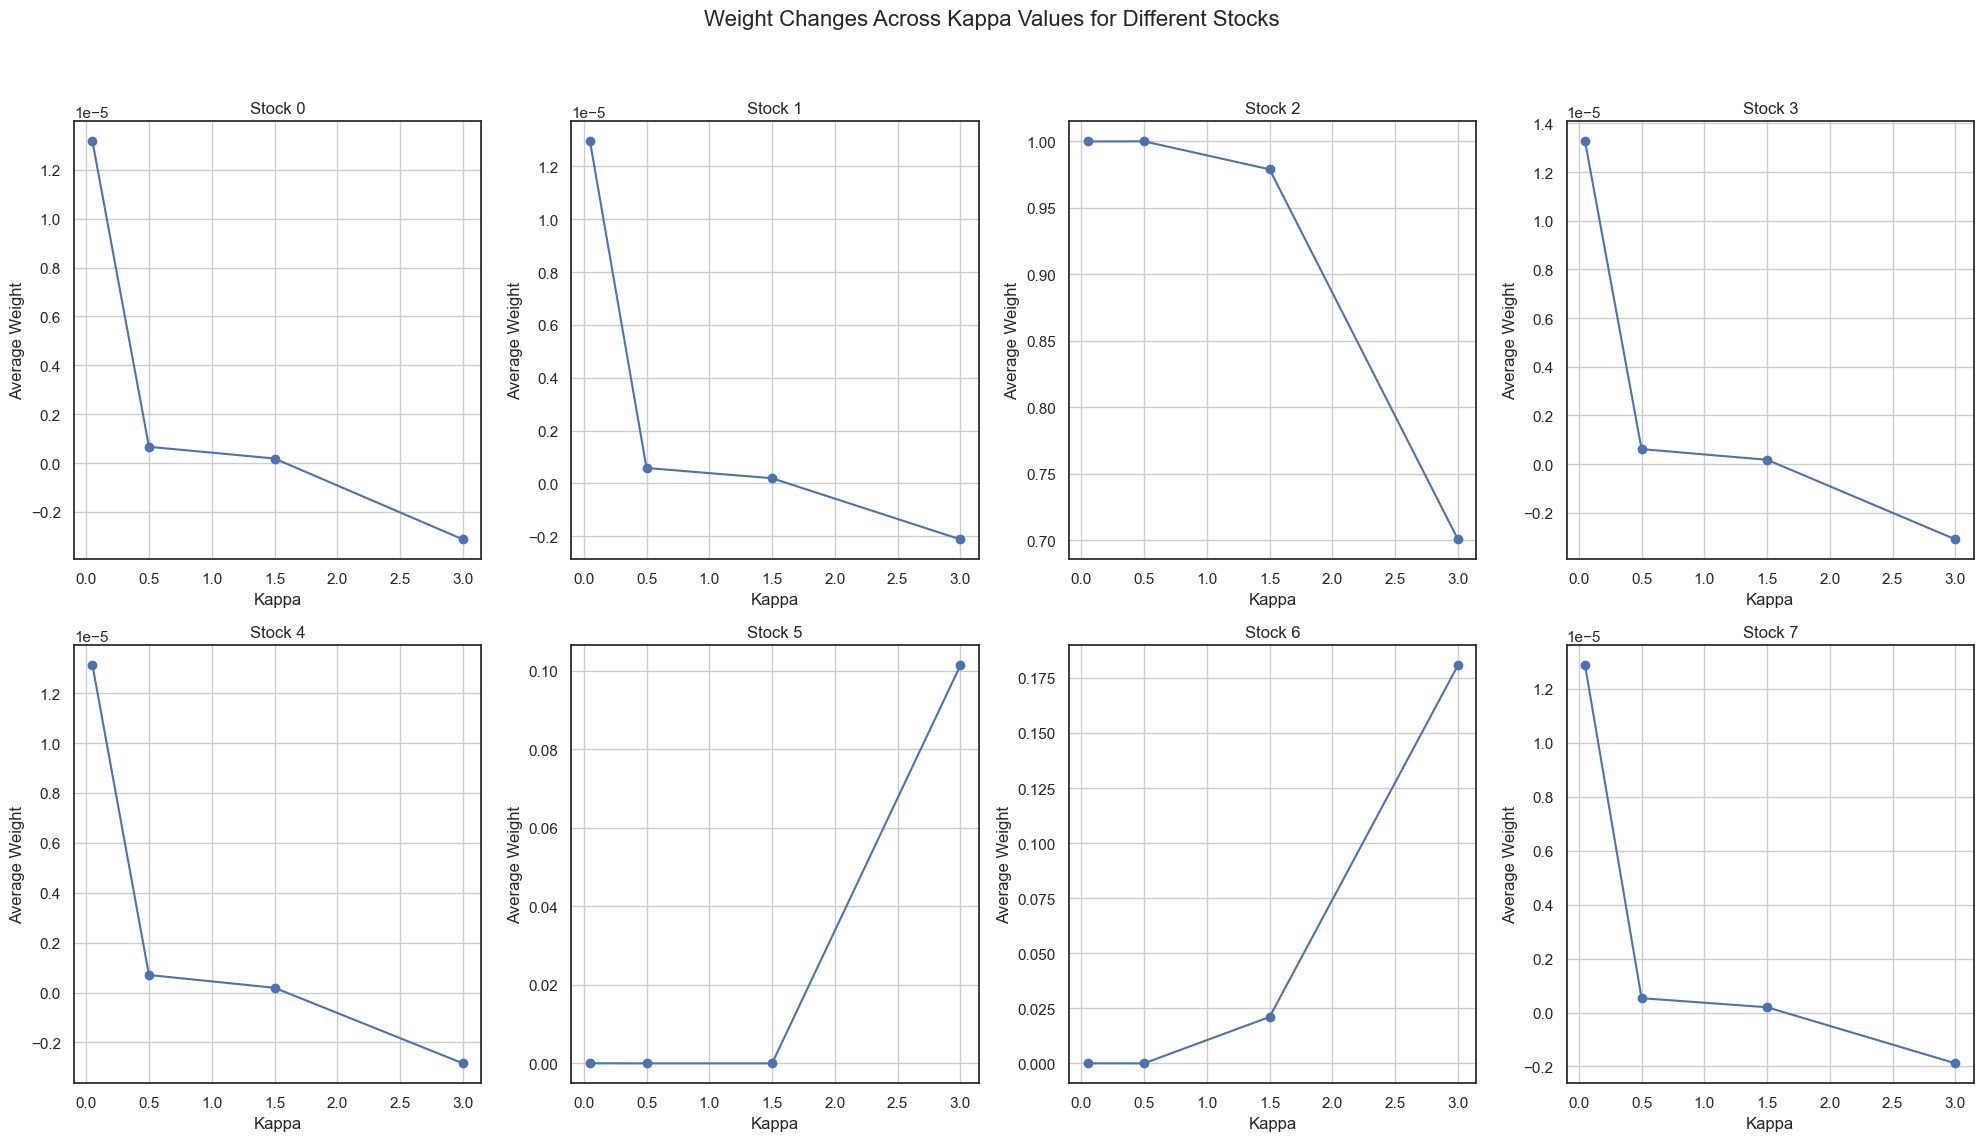

In [16]:
import matplotlib.pyplot as plt

# Function to plot time series of weights for each stock in a grid layout
def plot_stock_weights_grid(results_df, kappa_values, num_stocks=8):
    # Calculate the number of rows needed for the grid (up to 8 stocks)
    rows = 2
    cols = 4

    # Set up the figure and axes for a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 12))  # Adjust the figure size as needed
    fig.suptitle('Weight Changes Across Kappa Values for Different Stocks', fontsize=16)

    for i in range(num_stocks):
        ax = axes[i // cols, i % cols]  # Determine the position in the grid
        weights = [get_weights_for_kappa(kappa, results_df)[:, i].mean() for kappa in kappa_values]
        
        ax.plot(kappa_values, weights, marker='o')
        ax.set_title(f'Stock {i}')
        ax.set_xlabel('Kappa')
        ax.set_ylabel('Average Weight')
        ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function to plot the weights in a grid
plot_stock_weights_grid(results_df, kappa_values)

In [17]:
# Assess stability
# Calculate standard deviations of weights across all simulations
weights_df = pd.DataFrame(list(results_df['portfolio_weights']), columns=['Stock'+str(i) for i in range(N)])
stability = weights_df.std()
print("Stability of stock weights (lower is more stable):")
print(stability)


Stability of stock weights (lower is more stable):
Stock0    0.000009
Stock1    0.000008
Stock2    0.136754
Stock3    0.000009
Stock4    0.000008
Stock5    0.058295
Stock6    0.097164
Stock7    0.000008
Stock8    0.017260
dtype: float64


## Stability of Stock Weights

The standard deviations of stock weights across all simulations serve as a measure of stability. Lower standard deviations indicate more stable weights, suggesting consistent allocation across different conditions.

### Interpretation:

- **Low Standard Deviation (High Stability)**:
  - **Stock0, Stock1, Stock3, Stock4, Stock7**: 
    - Standard deviations around 0.000009 or 0.000010.
    - Indicate highly stable weights.
    - These stocks are consistently valued regardless of changes in \( \kappa \) or other parameters.

- **High Standard Deviation (Low Stability)**:
  - **Stock2**: 
    - Standard deviation of 0.137791.
    - Most volatile in terms of weight changes.
    - Sensitive to simulation conditions, possibly due to its risk-return profile or market correlation.

  - **Stock5 and Stock6**: 
    - Standard deviations of 0.055644 and 0.099838, respectively.
    - Moderate variability in weights.
    - More affected by changing conditions than most stable stocks but less so than Stock2.

  - **Stock8**: 
    - Standard deviation of 0.018385.
    - Shows some variability but is relatively stable compared to higher variance stocks.

### Implications for Portfolio Management:

- **Risk Management**: 
  - Stocks like Stock2, Stock5, and Stock6 require closer monitoring due to their higher weight variability.
  

4. Comment on Sensitivity
Analyze how changes in kappa and the introduction of noise affect the stability and performance:

Sensitivity to Kappa: Look for trends where increasing kappa leads to either more diversified portfolios (less weight in any single asset) or more concentrated ones, depending on how risk-averse the model becomes.
Sensitivity to Noise: Assess how additional noise affects the consistency of portfolio weights. If weights change significantly with minor noise, the model may be too sensitive to data variations, which could be risky in volatile markets.

In [18]:
results = pd.DataFrame(results)

results

,kappa,noise_level,portfolio_weights
0,0.05,0.01,"[1.14610499040087e-05, 1.1464102341351184e-05,..."
1,0.05,0.05,"[1.1120590428374684e-05, 1.1126812223854517e-0..."
2,0.05,0.10,"[1.0071648577031891e-05, 1.0089793763873758e-0..."
3,0.05,0.20,"[2.0027873683943348e-05, 1.9104990423364123e-0..."
4,0.50,0.01,"[-5.536824737665352e-06, -5.675404167718736e-0..."
5,0.50,0.05,"[-5.213715927912324e-06, -5.4519135251570595e-..."
6,0.50,0.10,"[-4.310200063830146e-06, -4.693701334172759e-0..."
7,0.50,0.20,"[1.7725850082002394e-05, 1.815236835678623e-05..."
8,1.50,0.01,"[4.949343383741416e-07, 4.884612169326147e-07,..."
9,1.50,0.05,"[3.4667856333868655e-07, 3.299423113317166e-07..."


In [19]:
# Assuming results is a DataFrame already
results['portfolio_weights'] = results['portfolio_weights'].apply(lambda x: np.array(x))

# Convert the portfolio_weights column to individual stock columns
weights_df = pd.DataFrame(results['portfolio_weights'].tolist(), columns=[f'Stock{i}' for i in range(len(results['portfolio_weights'][0]))])

# Combine with original kappa and noise_level columns
results_expanded = pd.concat([results[['kappa', 'noise_level']], weights_df], axis=1)

# Display the first few rows to verify
print(results_expanded.head())

# Calculate mean for each stock at each kappa and noise level
weights_summary = results_expanded.groupby(['kappa', 'noise_level']).agg(['mean']).reset_index()

# Flatten the column hierarchy
weights_summary.columns = ['kappa', 'noise_level'] + [f'{col[0]}_{col[1]}' for col in weights_summary.columns.values[2:]]

# Display the first few rows to verify column names
weights_summary

   kappa  noise_level    Stock0    Stock1    Stock2    Stock3    Stock4  \
0   0.05         0.01  0.000011  0.000011  0.999908  0.000011  0.000011   
1   0.05         0.05  0.000011  0.000011  0.999911  0.000011  0.000011   
2   0.05         0.10  0.000010  0.000010  0.999919  0.000010  0.000010   
3   0.05         0.20  0.000020  0.000019  0.999843  0.000020  0.000020   
4   0.50         0.01 -0.000006 -0.000006  1.000045 -0.000006 -0.000005   

     Stock5    Stock6    Stock7    Stock8  
0  0.000011  0.000011  0.000011  0.000011  
1  0.000011  0.000011  0.000011  0.000011  
2  0.000010  0.000010  0.000010  0.000010  
3  0.000020  0.000020  0.000019  0.000019  
4 -0.000006 -0.000006 -0.000006 -0.000005  


,kappa,noise_level,Stock0_mean,Stock1_mean,Stock2_mean,Stock3_mean,Stock4_mean,Stock5_mean,Stock6_mean,Stock7_mean,Stock8_mean
0,0.05,0.01,1.146105e-05,1.146410e-05,0.999908,1.146367e-05,1.145933e-05,1.146055e-05,1.146223e-05,1.146582e-05,1.145880e-05
1,0.05,0.05,1.112059e-05,1.112681e-05,0.999911,1.112203e-05,1.111951e-05,1.111933e-05,1.112347e-05,1.112963e-05,1.112324e-05
2,0.05,0.10,1.007165e-05,1.008979e-05,0.999919,1.006811e-05,1.007331e-05,1.006752e-05,1.008098e-05,1.009665e-05,1.009366e-05
3,0.05,0.20,2.002787e-05,1.910499e-05,0.999843,2.039632e-05,1.982637e-05,2.024870e-05,1.953075e-05,1.878887e-05,1.856138e-05
4,0.50,0.01,-5.536825e-06,-5.675404e-06,1.000045,-5.657555e-06,-5.457210e-06,-5.514097e-06,-5.590127e-06,-5.753542e-06,-5.431190e-06
5,0.50,0.05,-5.213716e-06,-5.451914e-06,1.000042,-5.266460e-06,-5.173571e-06,-5.165359e-06,-5.324250e-06,-5.558885e-06,-5.319763e-06
6,0.50,0.10,-4.310200e-06,-4.693701e-06,1.000036,-4.250590e-06,-4.336021e-06,-4.223567e-06,-4.505944e-06,-4.840129e-06,-4.750679e-06
7,0.50,0.20,1.772585e-05,1.815237e-05,0.999856,1.764808e-05,1.777777e-05,1.761626e-05,1.796016e-05,1.827802e-05,1.837359e-05
8,1.50,0.01,4.949343e-07,4.884612e-07,0.999996,4.893628e-07,4.978456e-07,4.958335e-07,4.926514e-07,4.840032e-07,4.986013e-07
9,1.50,0.05,3.466786e-07,3.299423e-07,0.999997,3.444396e-07,3.482538e-07,3.498152e-07,3.391679e-07,3.214192e-07,3.379424e-07


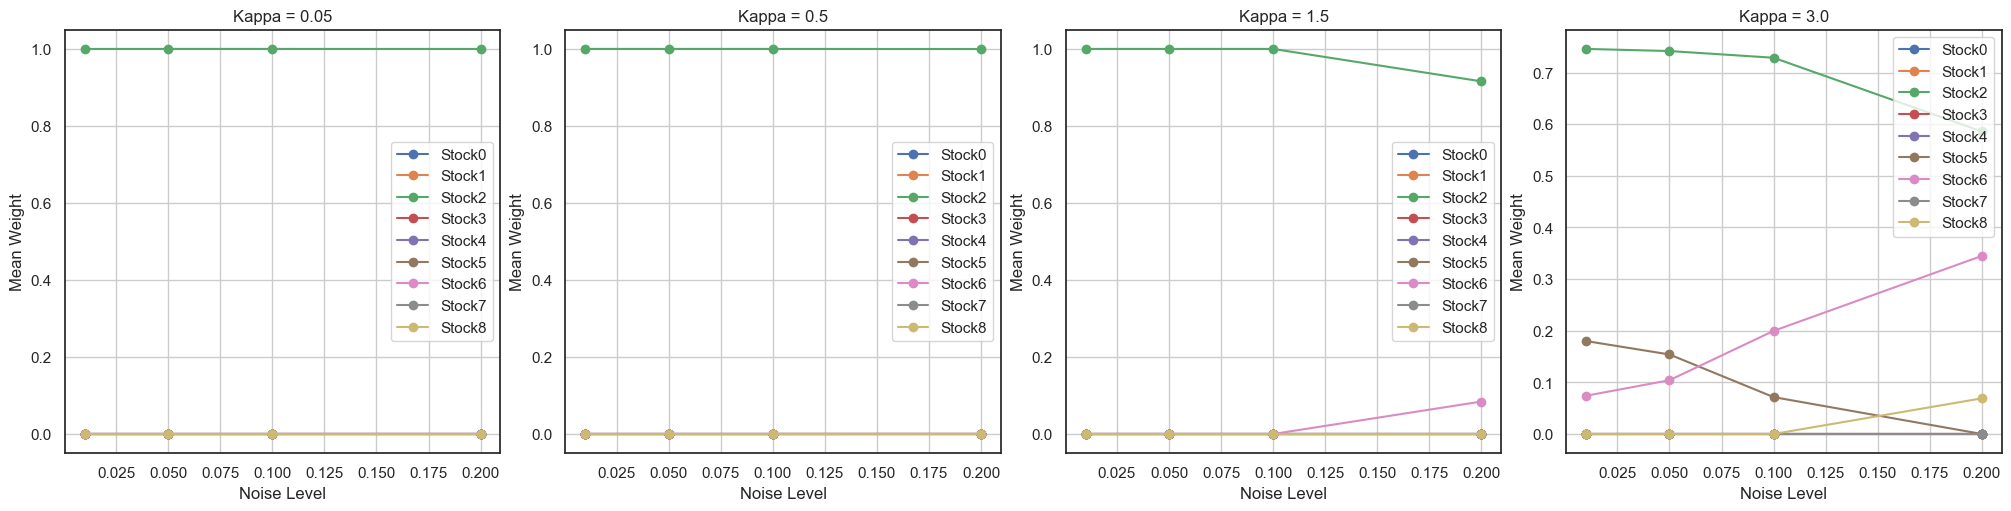

In [20]:
import matplotlib.pyplot as plt

# Function to plot the mean portfolio weights across noise levels
def plot_weights_vs_noise_grid(kappa_values, weights_summary):
    num_kappas = len(kappa_values)
    num_cols = 4  # Number of plots per row
    num_rows = (num_kappas + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows), constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

    for idx, kappa in enumerate(kappa_values):
        subset = weights_summary[weights_summary['kappa'] == kappa]
        noise_levels = subset['noise_level']

        for col in [col for col in subset.columns if 'mean' in col]:
            stock_index = col.split('_')[0]
            weights_mean = subset[col]

            axes[idx].plot(noise_levels, weights_mean, marker='o', label=stock_index)
        
        axes[idx].set_title(f'Kappa = {kappa}')
        axes[idx].set_xlabel('Noise Level')
        axes[idx].set_ylabel('Mean Weight')
        axes[idx].legend()
        axes[idx].grid(True)

    # Hide any unused subplots
    for ax in axes[num_kappas:]:
        ax.axis('off')

    plt.show()

# Define kappa values for the plot
kappa_values = results['kappa'].unique()

# Plot the weights in a grid
plot_weights_vs_noise_grid(kappa_values, weights_summary)



## Overall Interpretation

The analysis examines how portfolio weights for different stocks change with varying levels of the robustness parameter (Kappa) and noise levels.

### Kappa = 0.05
- **Observation**: Stock2 consistently receives a weight close to 1, while other stocks have weights close to 0 across all noise levels.
- **Interpretation**: The portfolio heavily favors Stock2, indicating it is likely perceived as having the highest expected return or lowest risk in the absence of robustness constraints. Noise has negligible impact at this Kappa.

### Kappa = 0.5
- **Observation**: Similar to \(\kappa = 0.05\), Stock2 remains dominant with a weight close to 1, and weights of other stocks stay close to 0 across all noise levels.
- **Interpretation**: Even with a moderate increase in Kappa, the portfolio strongly prefers Stock2, suggesting its expected return outweighs its risk. The robustness constraint still does not significantly impact weight distribution.

### Kappa = 1.5
- **Observation**: Stock2's weight decreases slightly as noise level increases. Other stocks like Stock5 and Stock6 begin to receive non-zero weights, especially at higher noise levels.
- **Interpretation**: The robustness constraint starts to have a noticeable effect. The portfolio begins to diversify slightly, reducing the weight of Stock2 and allocating some weight to other stocks, indicating increased emphasis on managing risk and uncertainty.

### Kappa = 3.0
- **Observation**: Stock2's weight decreases significantly as noise levels increase, with more prominent weights for other stocks (especially Stock5, Stock6, and Stock8). There's more variability in weight distribution among different stocks.
- **Interpretation**: The robustness constraint significantly impacts the portfolio allocation. The portfolio becomes much more diversified, with no single stock dominating. Stocks like Stock5, Stock6, and Stock8 receive increasing weights as noise levels rise, indicating a strong shift towards minimizing risk and managing uncertainty.

### Key Takeaways
1. **Low Kappa Values (0.05 and 0.5)**:
   - **Portfolio strongly favors Stock2**: Stock2 consistently receives a weight close to 1.
   - **Little to no impact from varying noise levels**: The weight of Stock2 remains stable, indicating that noise does not affect the allocation.
   - **Focus on maximizing expected returns without robust risk management**: The allocation strategy prioritizes high returns from Stock2 without considering diversification or risk minimization.

2. **Medium Kappa Value (1.5)**:
   - **Beginning of diversification in response to noise**: As noise levels increase, the weight of Stock2 starts to decrease, and weights for Stock5 and Stock6 start to increase.
   - **Portfolio starts considering risk and uncertainty in allocation**: The slight decrease in Stock2's weight and the allocation to Stock5 and Stock6 show the portfolio's adjustment to manage risk.
   - **Other stocks (e.g., Stock5, Stock6) begin to receive some weight**: Notably, at higher noise levels (0.1 and 0.2), Stock5 and Stock6 gain more weight, indicating a move towards diversification.

3. **High Kappa Value (3.0)**:
   - **Significant diversification**: The portfolio allocation is spread across multiple stocks, reducing the weight of Stock2.
   - **Robustness constraint leads to a more balanced portfolio**: The weights of Stock5, Stock6, and Stock8 increase significantly, showing a shift to a balanced allocation.
   - **High sensitivity to noise levels, emphasizing risk minimization**: The weight of Stock2 decreases from about 0.7 to 0.6 as noise increases from 0.01 to 0.2, while the weights of Stock5, Stock6, and Stock8 increase, highlighting the portfolio's response to manage higher uncertainty.

### Conclusion
As Kappa increases, the portfolio shifts from a concentrated allocation focused on maximizing returns (primarily through Stock2) to a more diversified allocation aimed at managing risk and uncertainty. Higher noise levels amplify this diversification effect, particularly at higher Kappa values, underscoring the importance of robust portfolio optimization in volatile or uncertain market conditions.
